In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
from xarray.coding.times import CFTimedeltaCoder

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True

import glob

## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

In [95]:
vegcolor=color=np.divide([176, 208, 65],255)
littercolor=np.divide([240, 155, 56],255)
soilcolor=np.divide([164, 119, 39],255)

In [67]:
outputdir= '/glade/work/aswann/datasets/'

soilC_wang=xr.open_dataset(outputdir +'wang2024_cSoil.nc') # US arctic only
soilC_HWSD2=xr.open_dataset(outputdir +'cSoil_fx_HWSD2_19600101-20220101.nc') #global
soilC_0p5=xr.open_dataset(outputdir +'soilc_0.5x0.5.nc') # high lat only
soilC_HSWD1=xr.open_dataset(outputdir +'soilc_0.5x0.5-2.nc')


In [9]:
soilC_0p5

<xarray.Dataset> Size: 1MB
Dimensions:       (lat: 360, nb: 2, lon: 720, time: 1)
Coordinates:
  * lat           (lat) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon           (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time          (time) object 8B 2000-07-02 12:00:00
Dimensions without coordinates: nb
Data variables:
    lat_bounds    (lat, nb) float32 3kB ...
    lon_bounds    (lon, nb) float32 6kB ...
    time_bounds   (time, nb) object 16B ...
    cSoilAbove1m  (time, lat, lon) float32 1MB ...
Attributes:
    Approach:             I just read the data from the original data file an...
    Temporal resolution:  yearly
    General information:  This product was derived from Northern Circumpolar ...
    Spatial resolution:   0.5x0.5 degree
    Derived data code:    http://redwood.ess.uci.edu/mingquan/www/ILAMB/Downl...
    history:              Tue Mar 19 20:16:17 2019: ncrename -v soilc,cSoilAb...

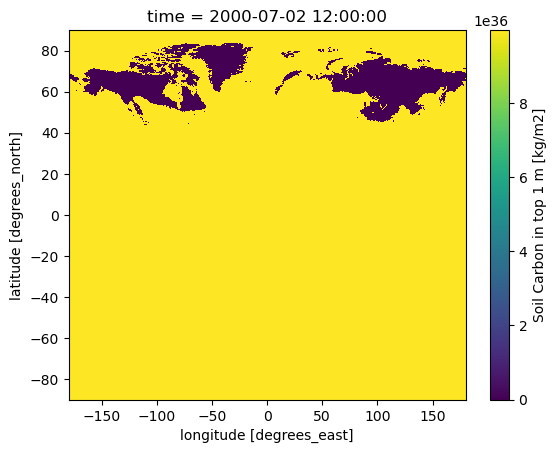

In [10]:
soilC_0p5['cSoilAbove1m'].plot()

In [11]:
soilC_HWSD2

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 1, lat: 360, lon: 720, bounds: 2)
Coordinates:
  * time         (time) datetime64[ns] 8B 1991-01-01
  * lon          (lon) float64 6kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat          (lat) float64 3kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
    time_bounds  (time, bounds) datetime64[ns] 16B ...
Dimensions without coordinates: bounds
Data variables:
    spatial_ref  int64 8B ...
    cSoil        (time, lat, lon) float32 1MB ...
Attributes:
    title:        Harmonized World Soil Database version 2.0 (HWSD v2.0) cSoil
    institution:  International Soil Reference and Information Centre (ISRIC)
    source:       Harmonized international soil profiles from WISE30sec 2015 ...
    history:      \n2024-10-01 14:59:28: downloaded source from https://www.i...
    references:   """\n    @techreport{Nachtergaele2023,\n    author      = {...
    comment:      
    Conventions:  CF 1.12

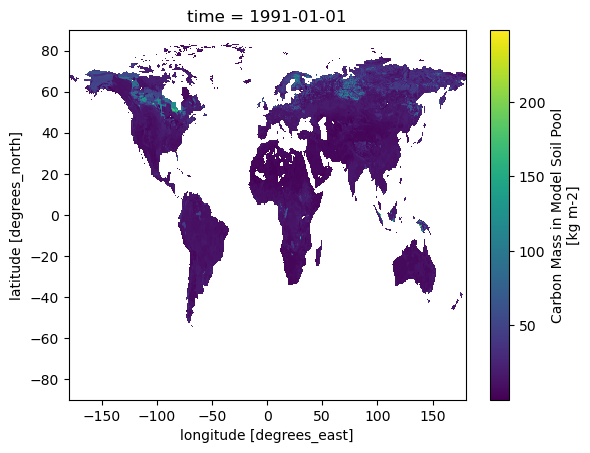

In [12]:
soilC_HWSD2['cSoil'].plot()

In [15]:
soilC_HSWD1

<xarray.Dataset> Size: 1MB
Dimensions:       (lat: 360, nb: 2, lon: 720, time: 1)
Coordinates:
  * lat           (lat) float32 1kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon           (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time          (time) object 8B 2000-07-02 12:00:00
Dimensions without coordinates: nb
Data variables:
    lat_bounds    (lat, nb) float32 3kB ...
    lon_bounds    (lon, nb) float32 6kB ...
    time_bounds   (time, nb) object 16B ...
    cSoilAbove1m  (time, lat, lon) float32 1MB ...
Attributes:
    Approach:             I just read the data from the original data file an...
    Temporal resolution:  yearly
    General information:  This product was derived from Harmonized World Soil...
    Spatial resolution:   0.5x0.5 degree
    Derived data code:    http://redwood.ess.uci.edu/mingquan/www/ILAMB/Downl...
    history:              Tue Mar 19 20:15:17 2019: ncrename -v soilc,cSoilAb...

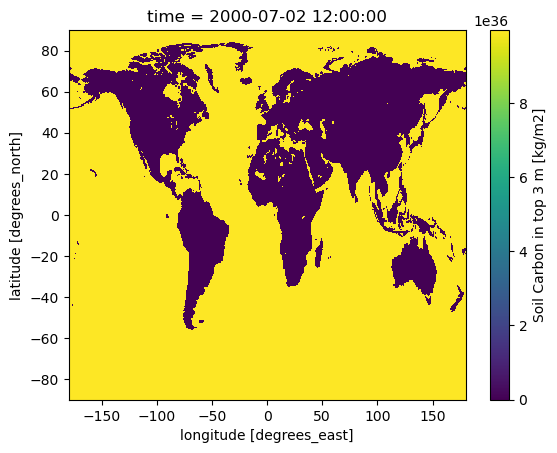

In [16]:
soilC_HSWD1['cSoilAbove1m'].plot()

In [75]:
# lets use HSWD2
soilCdb=soilC_HWSD2.copy(deep=True)

# convert longitude 
lon=soilCdb['lon'].values
lon360=np.where(lon<0,lon +360,lon)
soilCdb['lon']=lon360 # convert lon to 0-360


soilCdb = soilCdb.sortby(soilCdb.lon)
# soilCdb['lon'].values

In [76]:
soilCdb


<xarray.Dataset> Size: 1MB
Dimensions:      (time: 1, lat: 360, lon: 720, bounds: 2)
Coordinates:
  * time         (time) datetime64[ns] 8B 1991-01-01
  * lon          (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * lat          (lat) float64 3kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
    time_bounds  (time, bounds) datetime64[ns] 16B ...
Dimensions without coordinates: bounds
Data variables:
    spatial_ref  int64 8B ...
    cSoil        (time, lat, lon) float32 1MB ...
Attributes:
    title:        Harmonized World Soil Database version 2.0 (HWSD v2.0) cSoil
    institution:  International Soil Reference and Information Centre (ISRIC)
    source:       Harmonized international soil profiles from WISE30sec 2015 ...
    history:      \n2024-10-01 14:59:28: downloaded source from https://www.i...
    references:   """\n    @techreport{Nachtergaele2023,\n    author      = {...
    comment:      
    Conventions:  CF 1.12

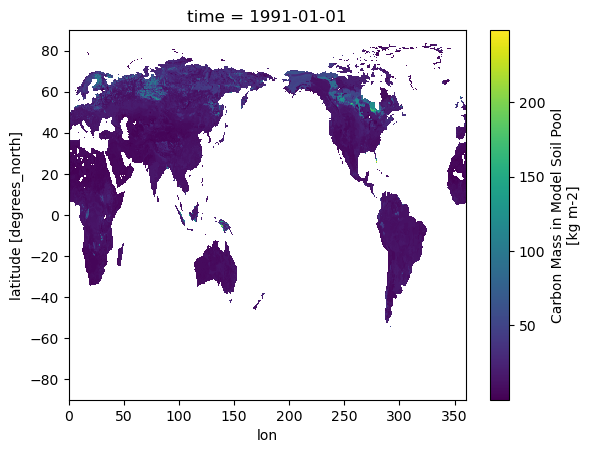

In [77]:
cSoil=soilCdb['cSoil']

# cSoil.mean(dim='lon').plot()
cSoil.plot()

In [38]:
# to get total carbon we need to know the zonal total land area

In [39]:
from loading_function_flat10 import  load_grid


outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']
modellist=modellist_orig

# initialize a dictionary to hold grid data
data_dict={}
data_dict = load_grid(data_dict,modellist)

ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
HadCM3LC-Bris getting grid info
UKESM1.2 getting grid info


In [40]:
model='CESM2' # this is the highest resolution model

#--- get area and land fraction
ds_area = data_dict[model +'_' +'areacella']
ds_landfrac = data_dict[model +'_' +'landfrac']

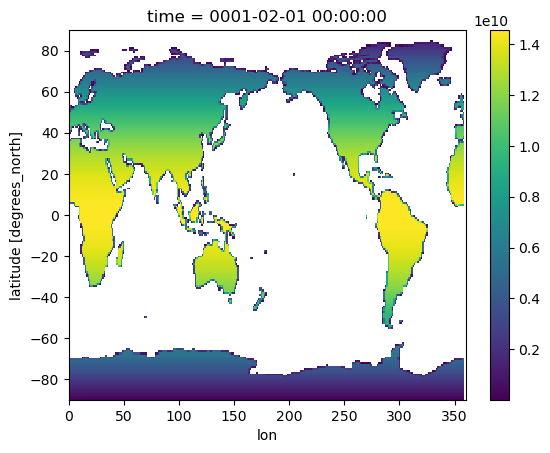

In [84]:
# interpolate to the soilC grid
area = ds_area['areacella'].squeeze().interp_like(soilCdb, method='nearest')
landfrac=ds_landfrac['sftlf'].interp_like(soilCdb, method='nearest')

# if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
#     landfrac=landfrac/100

landarea=(area*landfrac)

landarea.plot()

In [85]:
landfrac

<xarray.DataArray 'sftlf' (lat: 360, lon: 720)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 1.,  1.,  1., ...,  1., nan, nan],
       [ 1.,  1.,  1., ...,  1., nan, nan],
       [ 1.,  1.,  1., ...,  1., nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
Attributes:
    long_name:  land fraction

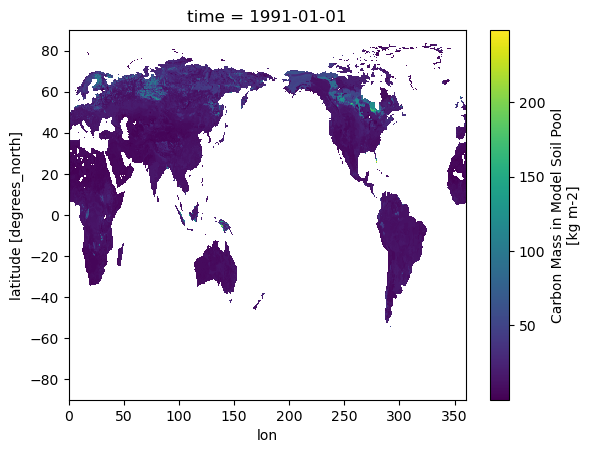

In [79]:
cSoil.plot()

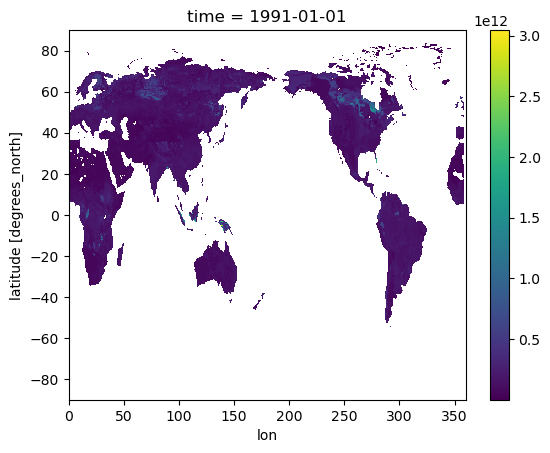

In [86]:
(cSoil*landarea).plot()

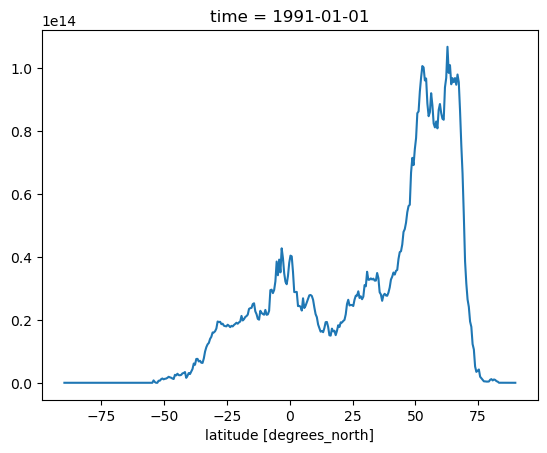

In [87]:
(cSoil*landarea).sum(dim='lon').plot()

In [91]:
zonalprofile=(cSoil*landarea).sum(dim='lon')*1e-15 # convert to PgC

zonalprofile.squeeze()

<xarray.DataArray (lat: 360)> Size: 1kB
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.38454589e-05, 3.57419311e-04, 5.22358576e-04,
       9.02227708e-04, 1.05171127e-03, 7.40710879e-04, 1.15824561e-03,
       9.63687198e-04, 4.08558233e-04, 3.74539697e-04, 3.82286700e-04,
       4.43073688e-04, 4.56504931e-04, 9.50105255e-04, 1.48924475e-03,
       1.92804716e-03, 4.22043446e-03, 3.81160737e-03, 3.46677424e-03,
       5.15337754e-03, 1.05823297e-02, 1.22869210e-02, 1.77488867e-02,
       1.94471423e-02, 2.40906011e-02, 2.64535323e-02, 3.15147899e-02,
       3.85660380e-02, 5.32783903e-02, 6.64585307e-02, 7.55616426e-02,
       8.64179432e-02, 9.54446420e-02, 9.78878587e-02, 9.46425050e-02,
       9.67647135e-02, 9.54787359e-02, 9.67402235e-02, 9.47914794e-02,
       1.00848325e-01, 9.84054953e-02, 1.06691353e-01, 9.68307331e-02,
       9.38164666e-02, 8.35212097e-02, 8.38372484e-02, 8.56290311e-02,
       8.85252208e-02, 8.66621211e-02, 8.07910711e-02, 8.29745904e-02,
       8.10952857e-02, 8.23052004e-02, 8.81109610e-02, 9.19426605e-02,
       8.59536901e-02, 8.46482962e-02, 8.86524841e-02, 9.66269448e-02,
       9.60052684e-02, 1.00125961e-01, 1.00571968e-01, 9.69279334e-02,
       9.24793705e-02, 8.61813799e-02, 8.55959728e-02, 7.77079314e-02,
...
       6.46569068e-04, 0.00000000e+00, 0.00000000e+00, 2.39851623e-04,
       7.55709887e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 1991-01-01
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

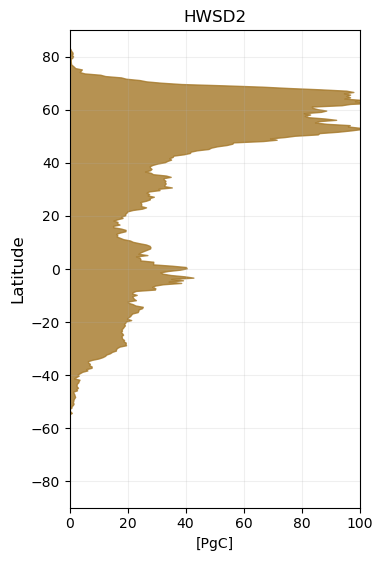

In [99]:
num_rows=1
num_cols=1
fig, ax = plt.subplots(num_rows,num_cols,figsize=(3.74 * num_cols, num_rows * 6.2 )) # initial C

lat=cSoil.lat
zonalprofile=(cSoil*landarea).sum(dim='lon').squeeze()*1e-12 # convert to PgC

# ax.plot(zonalprofile,lat, linestyle='-',color=mcolor,label='Total C')


# plot shaded area
# soil, soil to veg
#ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
fg = ax.fill_betweenx(lat,0, zonalprofile,alpha=0.8,color=soilcolor,label='cSoil')

ax.set_ylim([-90, 90])
ax.grid(True,alpha=0.2, zorder=0)
ax.set_ylabel('Latitude',fontsize=12)
ax.set_title('HWSD2')
ax.set_xlim([0, 100])


ax.set_xlabel('[PgC]')
# ax.annotate(subplotlabelnames[m],
#                      xy=(0, 1), xycoords='axes fraction',
#                      xytext=(+0.5, -0.5), textcoords='offset fontsize',
#                      fontsize='large', verticalalignment='top')

# plt.show()
plt.savefig("figures/zonal_cSoil_obs_HWSD2.pdf", bbox_inches='tight')
plt.show()
plt.close()

# Vegetation

In [100]:
cVeg=xr.open_dataset(outputdir +'XuSaatchi.nc')

In [101]:
cVeg

<xarray.Dataset> Size: 41MB
Dimensions:    (time: 20, lat: 360, lon: 720, nv: 2)
Coordinates:
  * lon        (lon) float64 6kB -179.7 -179.2 -178.7 ... 178.8 179.3 179.8
  * lat        (lat) float64 3kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * time       (time) object 160B 2000-07-02 12:00:00 ... 2019-07-02 12:00:00
Dimensions without coordinates: nv
Data variables:
    biomass    (time, lat, lon) float64 41MB ...
    time_bnds  (time, nv) object 320B ...
Attributes:
    title:        Changes in Global Terrestrial Live Biomass over the 21st Ce...
    version:      2
    institution:  Jet Propulsion Laboratory, California Institute of Technology
    source:       Estimates of carbon stock changes of live woody biomass fro...
    history:      \n2022-08-18: downloaded source from https://zenodo.org/rec...
    references:   \n@Xu2021{\n  author = {Xu, Liang, Saatchi, Sassan S., Yang...

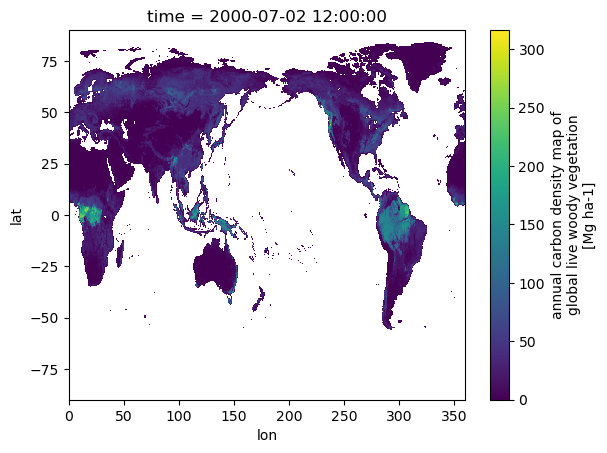

In [131]:
(cVeg[0,:,:]).plot()
# (cVeg[0,:,:]-cVeg[19,:,:]).plot()

In [119]:
# 
vegCdb=cVeg.copy(deep=True)

# convert longitude 
lon=vegCdb['lon'].values
lon360=np.where(lon<0,lon +360,lon)
vegCdb['lon']=lon360 # convert lon to 0-360


vegCdb = vegCdb.sortby(vegCdb.lon)
# vegCdb['lon'].values

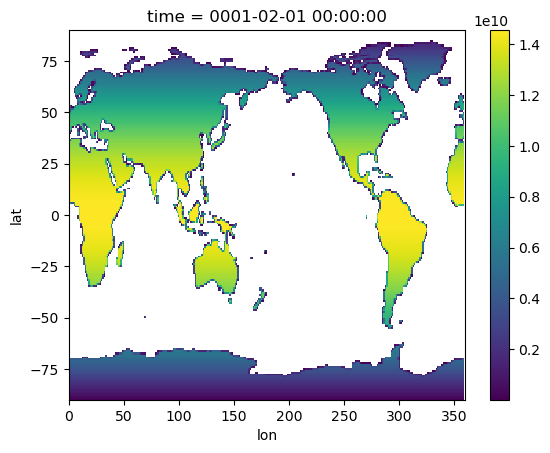

In [109]:
# interpolate to the soilC grid
area = ds_area['areacella'].squeeze().interp_like(vegCdb, method='nearest')
landfrac=ds_landfrac['sftlf'].interp_like(vegCdb, method='nearest')

# if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
#     landfrac=landfrac/100

landarea=(area*landfrac)

landarea.plot()

In [112]:
cVeg=vegCdb['biomass']

In [116]:
zonalprofile=(cVeg*landarea).sum(dim='lon').mean(dim='time').squeeze()*1e-12 # convert to PgC

zonalprofile

<xarray.DataArray (lat: 360)> Size: 3kB
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.07025979e-02, 2.60184637e-02, 3.35382084e-02,
       3.96497685e-02, 1.25443780e-01, 2.06637646e-01, 1.06249995e-01,
       1.11823685e-01, 3.25487907e-01, 3.48642721e-01, 3.07895570e-01,
       2.79523376e-01, 2.84384410e-01, 1.62702452e-01, 2.40206839e-01,
       6.97168587e-01, 5.61350080e-01, 4.23372310e-01, 4.38875245e-01,
       7.56279346e-01, 1.20153899e+00, 1.80075592e+00, 2.21741680e+00,
       4.59817916e+00, 7.37483876e+00, 1.08134163e+01, 1.58707701e+01,
       1.82432045e+01, 2.59037335e+01, 3.33664415e+01, 3.96403325e+01,
       4.96865687e+01, 5.59324061e+01, 6.18580172e+01, 6.49122123e+01,
       7.32591715e+01, 7.79208800e+01, 8.86434712e+01, 9.36653363e+01,
       9.68829492e+01, 1.03061713e+02, 1.07263093e+02, 1.11778230e+02,
       1.22558478e+02, 1.27175671e+02, 1.30725013e+02, 1.27955058e+02,
       1.25562106e+02, 1.19482914e+02, 1.19603305e+02, 1.13006730e+02,
       1.11704029e+02, 1.10386371e+02, 1.09285362e+02, 1.06919094e+02,
       1.06588275e+02, 1.05929221e+02, 1.04805974e+02, 1.00482815e+02,
       1.01474136e+02, 1.05535247e+02, 1.07179366e+02, 1.06620368e+02,
       1.09898036e+02, 1.09765495e+02, 1.13139283e+02, 1.05107571e+02,
...
       2.83969187e-01, 4.30133247e-01, 5.49692440e-01, 7.11771313e-01,
       1.14590996e+00, 8.93034736e-01, 9.59340617e-01, 6.77259286e-01,
       1.61545955e+00, 1.10270458e+00, 7.09291973e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])
Coordinates:
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

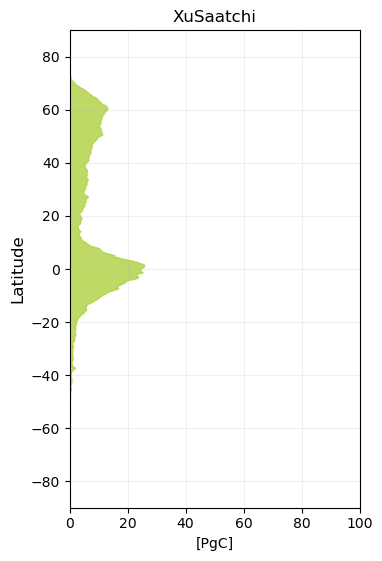

In [132]:
num_rows=1
num_cols=1
fig, ax = plt.subplots(num_rows,num_cols,figsize=(3.74 * num_cols, num_rows * 6.2 )) # initial C

lat=cVeg.lat
unitconvert= 1e-13#Mg/ha to Pg/m2, 1ha/m2=1e-4, Mg/Pg = 1e6/1e15 =1e-9 => 1e-13
zonalprofile=(cVeg*landarea).sum(dim='lon').mean(dim='time').squeeze()*unitconvert # convert to PgC

# ax.plot(zonalprofile,lat, linestyle='-',color=mcolor,label='Total C')


# plot shaded area
# soil, soil to veg
#ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
fg = ax.fill_betweenx(lat,0, zonalprofile,alpha=0.8,color=vegcolor,label='cVeg')

ax.set_ylim([-90, 90])
ax.grid(True,alpha=0.2, zorder=0)
ax.set_ylabel('Latitude',fontsize=12)
ax.set_title('XuSaatchi')
ax.set_xlim([0, 100])


ax.set_xlabel('[PgC]')
# ax.annotate(subplotlabelnames[m],
#                      xy=(0, 1), xycoords='axes fraction',
#                      xytext=(+0.5, -0.5), textcoords='offset fontsize',
#                      fontsize='large', verticalalignment='top')

# plt.show()
plt.savefig("figures/zonal_cVeg_obs_XuSaatchi.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [158]:
    
def load_observations(zonal):

    '''
     this function loads observational datasets

     inputs: flag that indicates output for zonal mean
     zonal = 0 full grid output only
     zonal = 1 also output zonal mean
     
     outputs:
     cSoil, cVeg, cSoil_zonal, cVeg_zonal
     
    '''

    # import numpy as np
    # import numpy.matlib
    # import numpy.ma as ma
    
    import xarray as xr
    # time_coder = xr.coders.CFDatetimeCoder(use_cftime=True) #create time coder with cftime
    
    # import time
    # import cftime
    # import netCDF4 as nc
    # from datetime import timedelta

    # cVeg
    # XuSaatchi.nc

    #-------- load data
    outputdir= '/glade/work/aswann/datasets/'

    cSoil=xr.open_dataset(outputdir +'cSoil_fx_HWSD2_19600101-20220101.nc') 
    cVeg=xr.open_dataset(outputdir +'XuSaatchi.nc')

    # ------- convert the longitude grid to 0 to 360
    # soil
    unitconvert_soil= 1e-12 #convert from kgC to PgC
    soilCdb=cSoil.copy(deep=True)
    # convert longitude 
    lon=soilCdb['lon'].values
    lon360=np.where(lon<0,lon +360,lon)
    soilCdb['lon']=lon360 # convert lon to 0-360
    soilCdb = soilCdb.sortby(soilCdb.lon)
    cSoil=soilCdb['cSoil']*unitconvert_soil # extract the variable and convert to PgC/m2
    
    # veg
    unitconvert_veg= 1e-13#Mg/ha to Pg/m2, 1ha/m2=1e-4, Mg/Pg = 1e6/1e15 =1e-9 => 1e-13
    vegCdb=cVeg.copy(deep=True)
    # convert longitude 
    lon=vegCdb['lon'].values
    lon360=np.where(lon<0,lon +360,lon)
    vegCdb['lon']=lon360 # convert lon to 0-360 
    vegCdb = vegCdb.sortby(vegCdb.lon)
    cVeg=vegCdb['biomass']*unitconvert_veg # extract the variable and convert to PgC/m2

    if zonal==0:
        print('full grid output only')
        return cSoil, cVeg
    else:
        print('creating zonal average output')
        #------- load area and land fraction from a model so we can area weight
        from loading_function_flat10 import  load_grid
    
        # load grid info for the highest resolution grid which we will interpolate
        outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'
        modellist=['CESM2']
        # initialize a dictionary to hold grid data
        data_dict={}
        data_dict = load_grid(data_dict,modellist)
    
        model='CESM2' # this is the highest resolution model
    
        #--- get area and land fraction
        ds_area = data_dict[model +'_' +'areacella']
        ds_landfrac = data_dict[model +'_' +'landfrac']
    
        #--------- calculate zonal profiles
        # interpolate to the cSoil grid
        area = ds_area['areacella'].squeeze().interp_like(soilCdb, method='nearest')
        landfrac=ds_landfrac['sftlf'].interp_like(soilCdb, method='nearest')
        cSoil_zonal=(cSoil*landfrac*area).sum(dim='lon').squeeze() 

        # interpolate to the cVeg grid
        area = ds_area['areacella'].squeeze().interp_like(vegCdb, method='nearest')
        landfrac=ds_landfrac['sftlf'].interp_like(vegCdb, method='nearest')
        cVeg_zonal=(cVeg*landfrac*area).sum(dim='lon').mean(dim='time').squeeze()
    
        return cSoil, cVeg, cSoil_zonal, cVeg_zonal

In [159]:
cSoil, cVeg, cSoil_zonal, cVeg_zonal = load_observations(1)

creating zonal average output
CESM2 getting grid info


In [166]:
cVeg_zonal

<xarray.DataArray (lat: 360)> Size: 3kB
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.07025978e-03, 2.60184636e-03, 3.35382083e-03,
       3.96497686e-03, 1.25443779e-02, 2.06637646e-02, 1.06249995e-02,
       1.11823685e-02, 3.25487907e-02, 3.48642722e-02, 3.07895570e-02,
       2.79523376e-02, 2.84384410e-02, 1.62702452e-02, 2.40206839e-02,
       6.97168590e-02, 5.61350081e-02, 4.23372311e-02, 4.38875244e-02,
       7.56279346e-02, 1.20153899e-01, 1.80075593e-01, 2.21741680e-01,
       4.59817916e-01, 7.37483876e-01, 1.08134163e+00, 1.58707701e+00,
       1.82432045e+00, 2.59037335e+00, 3.33664415e+00, 3.96403325e+00,
       4.96865687e+00, 5.59324061e+00, 6.18580172e+00, 6.49122123e+00,
       7.32591715e+00, 7.79208800e+00, 8.86434712e+00, 9.36653363e+00,
       9.68829493e+00, 1.03061713e+01, 1.07263093e+01, 1.11778230e+01,
       1.22558478e+01, 1.27175671e+01, 1.30725013e+01, 1.27955058e+01,
       1.25562106e+01, 1.19482914e+01, 1.19603305e+01, 1.13006730e+01,
       1.11704029e+01, 1.10386371e+01, 1.09285362e+01, 1.06919094e+01,
       1.06588275e+01, 1.05929221e+01, 1.04805974e+01, 1.00482815e+01,
       1.01474136e+01, 1.05535247e+01, 1.07179366e+01, 1.06620368e+01,
       1.09898036e+01, 1.09765495e+01, 1.13139283e+01, 1.05107571e+01,
...
       2.83969189e-02, 4.30133249e-02, 5.49692432e-02, 7.11771306e-02,
       1.14590995e-01, 8.93034726e-02, 9.59340622e-02, 6.77259292e-02,
       1.61545957e-01, 1.10270458e-01, 7.09291972e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])
Coordinates:
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

In [165]:
cSoil_zonal

<xarray.DataArray (lat: 360)> Size: 1kB
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.38454586e-02, 3.57419312e-01, 5.22358596e-01,
       9.02227640e-01, 1.05171156e+00, 7.40710855e-01, 1.15824568e+00,
       9.63687301e-01, 4.08558279e-01, 3.74539733e-01, 3.82286608e-01,
       4.43073630e-01, 4.56504852e-01, 9.50105071e-01, 1.48924470e+00,
       1.92804730e+00, 4.22043467e+00, 3.81160760e+00, 3.46677399e+00,
       5.15337753e+00, 1.05823240e+01, 1.22869120e+01, 1.77488995e+01,
       1.94471550e+01, 2.40905838e+01, 2.64535084e+01, 3.15147934e+01,
       3.85660629e+01, 5.32783546e+01, 6.64585419e+01, 7.55615158e+01,
       8.64177094e+01, 9.54444046e+01, 9.78878098e+01, 9.46425323e+01,
       9.67647629e+01, 9.54786682e+01, 9.67401276e+01, 9.47913742e+01,
       1.00848297e+02, 9.84053802e+01, 1.06691231e+02, 9.68307800e+01,
       9.38164215e+01, 8.35211639e+01, 8.38372192e+01, 8.56290512e+01,
       8.85251846e+01, 8.66620789e+01, 8.07910080e+01, 8.29745865e+01,
       8.10952911e+01, 8.23052063e+01, 8.81110077e+01, 9.19427109e+01,
       8.59536514e+01, 8.46483612e+01, 8.86525116e+01, 9.66269608e+01,
       9.60053482e+01, 1.00125916e+02, 1.00571938e+02, 9.69280167e+01,
       9.24794312e+01, 8.61813431e+01, 8.55959702e+01, 7.77078629e+01,
...
       6.46569073e-01, 0.00000000e+00, 0.00000000e+00, 2.39851624e-01,
       7.55709946e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 1991-01-01
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

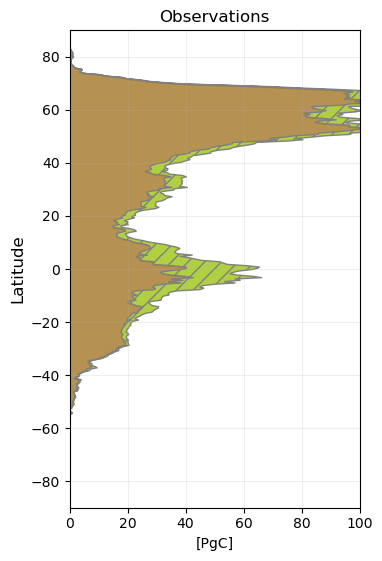

In [169]:
num_rows=1
num_cols=1
fig, ax = plt.subplots(num_rows,num_cols,figsize=(3.74 * num_cols, num_rows * 6.2 )) # initial C


# ax.plot(zonalprofile,lat, linestyle='-',color=mcolor,label='Total C')


# plot shaded area
# soil, soil to veg
#ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
fg = ax.fill_betweenx(lat,0, cSoil_zonal.values,alpha=0.8,color=soilcolor,label='Soil')
fg2 = ax.fill_betweenx(lat,cSoil_zonal.values, cSoil_zonal.values+cVeg_zonal.values,color=vegcolor,label='Veg',hatch='//',edgecolor='grey')
#,alpha=0.3

ax.set_ylim([-90, 90])
ax.grid(True,alpha=0.2, zorder=0)
ax.set_ylabel('Latitude',fontsize=12)
ax.set_title('Observations')
ax.set_xlim([0, 100])


ax.set_xlabel('[PgC]')
# ax.annotate(subplotlabelnames[m],
#                      xy=(0, 1), xycoords='axes fraction',
#                      xytext=(+0.5, -0.5), textcoords='offset fontsize',
#                      fontsize='large', verticalalignment='top')

# plt.show()
plt.savefig("figures/zonal_carbon_obs.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [153]:
#-------- load data
outputdir= '/glade/work/aswann/datasets/'

cSoil=xr.open_dataset(outputdir +'cSoil_fx_HWSD2_19600101-20220101.nc') 

# ------- convert the longitude grid to 0 to 360
# soil
unitconvert_soil= 1e-12 #convert from kgC to PgC
soilCdb=cSoil.copy(deep=True)
# convert longitude 
lon=soilCdb['lon'].values
lon360=np.where(lon<0,lon +360,lon)
soilCdb['lon']=lon360 # convert lon to 0-360
soilCdb = soilCdb.sortby(soilCdb.lon)
cSoil=soilCdb['cSoil']*unitconvert_soil # extract the variable and convert to PgC/m2



print('creating zonal average output')
#------- load area and land fraction from a model so we can area weight
from loading_function_flat10 import  load_grid

# load grid info for the highest resolution grid which we will interpolate
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'
modellist=['CESM2']
# initialize a dictionary to hold grid data
data_dict={}
data_dict = load_grid(data_dict,modellist)

model='CESM2' # this is the highest resolution model

#--- get area and land fraction
ds_area = data_dict[model +'_' +'areacella']
ds_landfrac = data_dict[model +'_' +'landfrac']

# interpolate to the cSoil grid
area = ds_area['areacella'].squeeze().interp_like(soilCdb, method='nearest')
landfrac=ds_landfrac['sftlf'].interp_like(soilCdb, method='nearest')
cSoil_zonal=(cSoil*landarea).sum(dim='lon').squeeze() 

creating zonal average output
CESM2 getting grid info


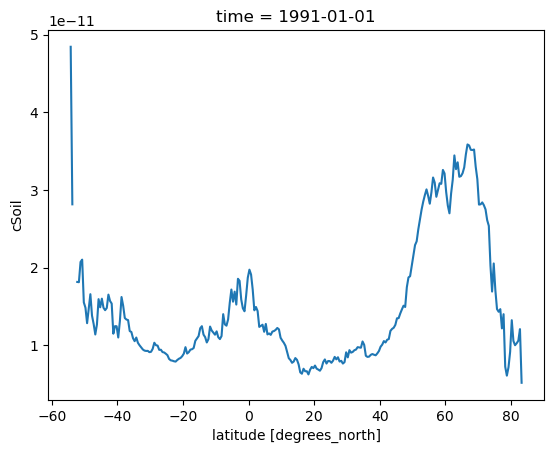

In [157]:
cSoil.mean(dim='lon').plot()

In [ ]:
cVeg=xr.open_dataset(outputdir +'XuSaatchi.nc')
# veg
unitconvert_veg= 1e-13#Mg/ha to Pg/m2, 1ha/m2=1e-4, Mg/Pg = 1e6/1e15 =1e-9 => 1e-13
vegCdb=cVeg.copy(deep=True)
# convert longitude 
lon=vegCdb['lon'].values
lon360=np.where(lon<0,lon +360,lon)
vegCdb['lon']=lon360 # convert lon to 0-360 
vegCdb = vegCdb.sortby(vegCdb.lon)
cVeg=vegCdb['biomass']*unitconvert_veg # extract the variable and convert to PgC/m2

print('creating zonal average output')
#------- load area and land fraction from a model so we can area weight
from loading_function_flat10 import  load_grid

# load grid info for the highest resolution grid which we will interpolate
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'
modellist=['CESM2']
# initialize a dictionary to hold grid data
data_dict={}
data_dict = load_grid(data_dict,modellist)

model='CESM2' # this is the highest resolution model

#--- get area and land fraction
ds_area = data_dict[model +'_' +'areacella']
ds_landfrac = data_dict[model +'_' +'landfrac']

#--------- calculate zonal profiles

# interpolate to the cVeg grid
area = ds_area['areacella'].squeeze().interp_like(vegCdb, method='nearest')
landfrac=ds_landfrac['sftlf'].interp_like(vegCdb, method='nearest')
cVeg_zonal=(cVeg*landarea).sum(dim='lon').mean(dim='time').squeeze()